In [1]:
!pip install qiskit qiskit_aer matplotlib numpy
!pip install pylatexenc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=51527fc66b66d9ece80d675c3bbc68df59681ab35617605b0bf63daa6b34d311
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector, plot_histogram
import numpy as np
import matplotlib.pyplot as plt

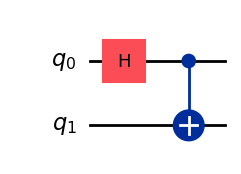

In [3]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw('mpl')

In [4]:
def qft_rotations(qc, n):
    """Apply QFT rotations recursively on the first n qubits."""
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qubit in range(n):
        qc.cp(np.pi / 2**(n - qubit), qubit, n)
    qft_rotations(qc, n)
    return qc

def swap_registers(qc, n):
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    return qc

def qft_circuit(n):
    qc = QuantumCircuit(n)
    qft_rotations(qc, n)
    swap_registers(qc, n)
    qc.name = "QFT"
    return qc

In [5]:
# Inverse QFT

def inverse_qft_circuit(n):
    qc = QuantumCircuit(n)
    # Reverse of swap_registers
    swap_registers(qc, n)
    # Apply inverse rotations
    for qubit in range(n):
        for k in range(qubit):
            qc.cp(-np.pi / 2**(qubit - k), k, qubit)
        qc.h(qubit)
    qc.name = "Inverse QFT"
    return qc

In [6]:
# Run & Visualize

def run_qft(n):
    """Execute QFT and visualize state + circuit."""
    qc = qft_circuit(n)
    simulator = AerSimulator(method='statevector')
    qc.save_statevector()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled).result()
    statevector = result.data(0)["statevector"]

    # Visualization
    print(f"\n--- QFT Circuit for {n} Qubits ---")
    display(qc.draw('mpl'))
    plot_bloch_multivector(statevector)
    plt.show()

In [7]:
# Add Measurements

def qft_with_measurement(n):
    """Run QFT circuit and measure output states."""
    qc = qft_circuit(n)
    qc.measure_all()

    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1024).result()
    counts = result.get_counts()

    print(f"\n--- Measured Output for {n} Qubits ---")
    display(qc.draw('mpl'))
    plot_histogram(counts)
    plt.show()

In [8]:
# Phase Estimation Example

def phase_estimation_example():
    """Integrate QFT into a simple phase estimation circuit."""
    from qiskit.circuit.library import PhaseGate

    n_count = 3  # counting qubits
    qc = QuantumCircuit(n_count + 1, n_count)

    # Apply Hadamard to counting qubits
    qc.h(range(n_count))
    # Target qubit in |1>
    qc.x(n_count)

    # Define a unitary U with known phase = 1/4 (pi/2)
    phase = 1/4
    for qubit in range(n_count):
        qc.cp(2 * np.pi * phase * (2 ** qubit), qubit, n_count)

    # Apply inverse QFT on counting qubits
    iqft = inverse_qft_circuit(n_count)
    qc.append(iqft.to_gate(), range(n_count))

    qc.measure(range(n_count), range(n_count))

    # Run simulation
    simulator = AerSimulator()
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=1024).result()
    counts = result.get_counts()

    print("\n--- Phase Estimation Circuit ---")
    display(qc.draw('mpl'))
    plot_histogram(counts)
    plt.show()


--- QFT Circuit for 2 Qubits ---


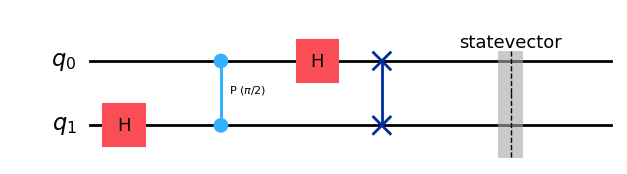


--- QFT Circuit for 3 Qubits ---


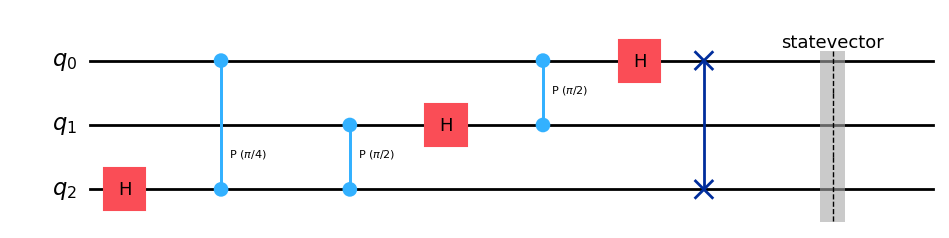


--- QFT Circuit for 4 Qubits ---


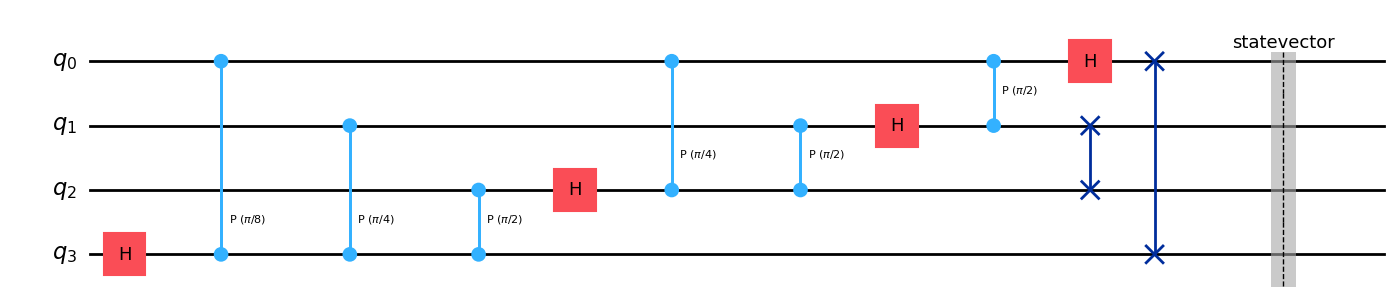


--- task2: Inverse QFT (3 qubits) ---


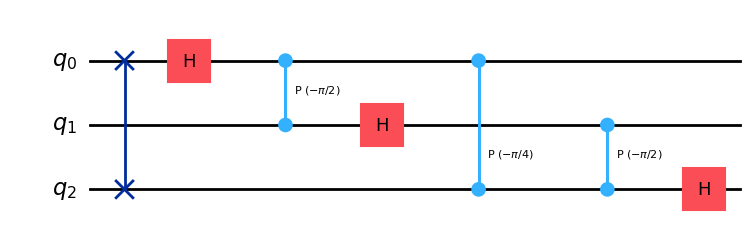


--- Phase Estimation Circuit ---


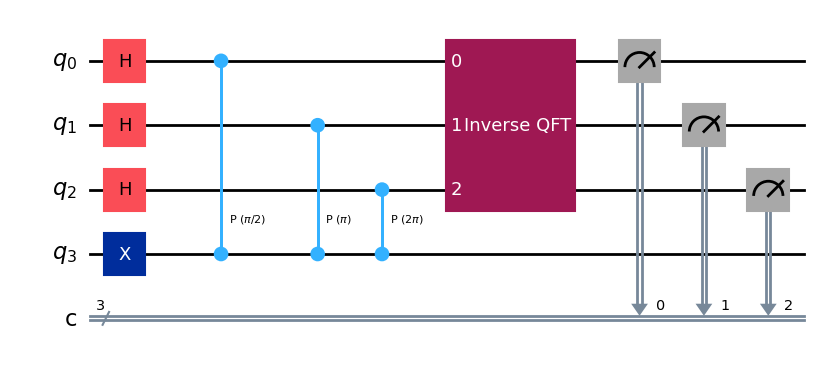


--- Measured Output for 3 Qubits ---


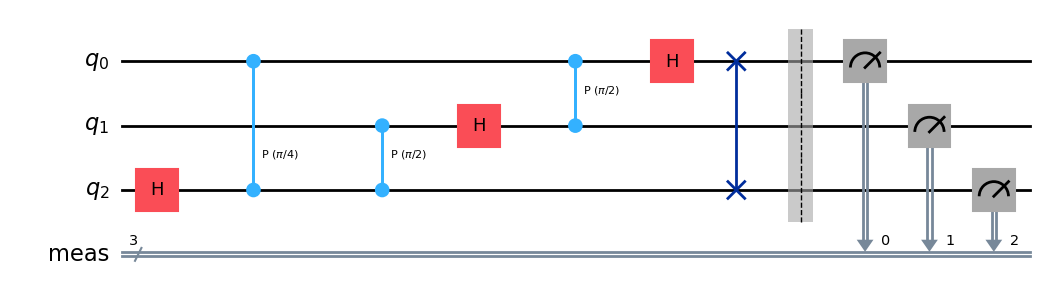

In [10]:
if __name__ == "__main__":
    # Task 1: Vary number of qubits
    for n in [2, 3, 4]:
        run_qft(n)

    # Task 2: Inverse QFT
    print("\n--- task2: Inverse QFT (3 qubits) ---")
    iqft = inverse_qft_circuit(3)
    display(iqft.draw('mpl'))

    # Task 3: Phase Estimation Integration
    phase_estimation_example()

    # Task 4: Measurement and Probability
    qft_with_measurement(3)